In [101]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from scipy.stats import norm
from scipy.ndimage import gaussian_filter1d
import yfinance as yf
from scipy.interpolate import interp1d
from scipy.optimize import minimize_scalar
from scipy.integrate import trapz
from scipy.misc import derivative
from scipy.integrate import simps
from scipy.optimize import curve_fit

Spot price of underlying = 332

In [102]:
calls = pd.read_excel("SPY_191020exp_290920.xlsx", sheet_name="call")
calls["midprice"] = (calls.bid + calls.ask)/2
calls = calls[calls.midprice > 0]
calls

,strike,lastPrice,change,bid,ask,BxA,volume,openInterest,midprice
0,170,0.00,0.0,163.70,164.06,146 x 146,0,0,163.880
1,175,0.00,0.0,158.70,159.06,146 x 146,0,0,158.880
2,180,0.00,0.0,153.69,154.05,146 x 102,0,0,153.870
3,185,0.00,0.0,148.70,149.04,146 x 102,0,0,148.870
4,190,0.00,0.0,143.70,144.06,146 x 146,0,0,143.880
...,...,...,...,...,...,...,...,...,...
110,405,0.01,0.0,0.00,0.01,0 x 11065,0,28,0.005
111,410,0.02,0.0,0.00,0.01,0 x 8620,0,200,0.005
112,415,0.01,0.0,0.00,0.01,0 x 8630,0,5,0.005
113,420,0.02,0.0,0.00,0.01,0 x 8641,0,55,0.005


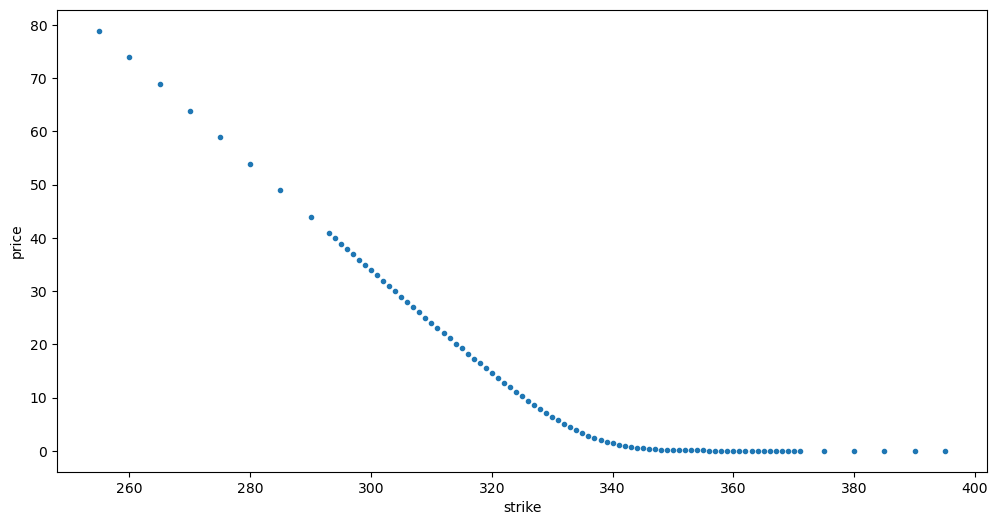

In [103]:
calls_sub = calls[(calls.strike > 250) & (calls.strike < 400)]
plt.figure(figsize=(12,6))
plt.plot(calls_sub.strike, calls_sub.midprice, ".");
plt.xlabel("strike")
plt.ylabel("price")
#plt.savefig("call_prices.png", dpi=400)
plt.show()

## Implied Volatility Surface

In [104]:
def call_value(S, K, sigma, t=0, r=0):
    # use np.multiply and divide to handle divide-by-zero
    with np.errstate(divide='ignore'):
        d1 = np.divide(1, sigma * np.sqrt(t)) * (np.log(S/K) + (r+sigma**2 / 2) * t)
        d2 = d1 - sigma * np.sqrt(t)
    return np.multiply(norm.cdf(d1),S) - np.multiply(norm.cdf(d2), K * np.exp(-r * t))

def call_vega(S, K, sigma, t=0, r=0):
    with np.errstate(divide='ignore'):
        d1 = np.divide(1, sigma * np.sqrt(t)) * (np.log(S/K) + (r+sigma**2 / 2) * t)
    return np.multiply(S, norm.pdf(d1)) * np.sqrt(t)

def bs_iv(price, S, K, t=0, r=0, precision=1e-4, initial_guess=0.2, max_iter=1000, verbose=False):
    iv = initial_guess
    for _ in range(max_iter):
        P = call_value(S, K, iv, t, r)
        diff = price - P
        if abs(diff) < precision:
            return iv
        grad = call_vega(S, K, iv, t, r)
        iv += diff/grad     
    if verbose:
        print(f"Did not converge after {max_iter} iterations")
    return iv 

In [105]:
S = 332
t = 3/52
calls["iv"] = calls.apply(lambda row: bs_iv(row.midprice, S, row.strike, t, max_iter=500), axis=1)

C:\Users\ANDREAS\AppData\Local\Temp\ipykernel_13444\2692504730.py:21: RuntimeWarning: divide by zero encountered in double_scalars
  iv += diff/grad
C:\Users\ANDREAS\AppData\Local\Temp\ipykernel_13444\2692504730.py:4: RuntimeWarning: invalid value encountered in double_scalars
  d1 = np.divide(1, sigma * np.sqrt(t)) * (np.log(S/K) + (r+sigma**2 / 2) * t)
C:\Users\ANDREAS\AppData\Local\Temp\ipykernel_13444\2692504730.py:10: RuntimeWarning: invalid value encountered in double_scalars
  d1 = np.divide(1, sigma * np.sqrt(t)) * (np.log(S/K) + (r+sigma**2 / 2) * t)


In [106]:
def plot_vol_smile(calls, savefig=False):
    plt.figure(figsize=(9,6))
    plt.plot(calls.strike, calls.iv, ".")
    plt.xlabel("Strike")
    plt.ylabel("IV")
    if savefig:
        plt.savefig("vol_smile.png",dpi=300)
    plt.show()

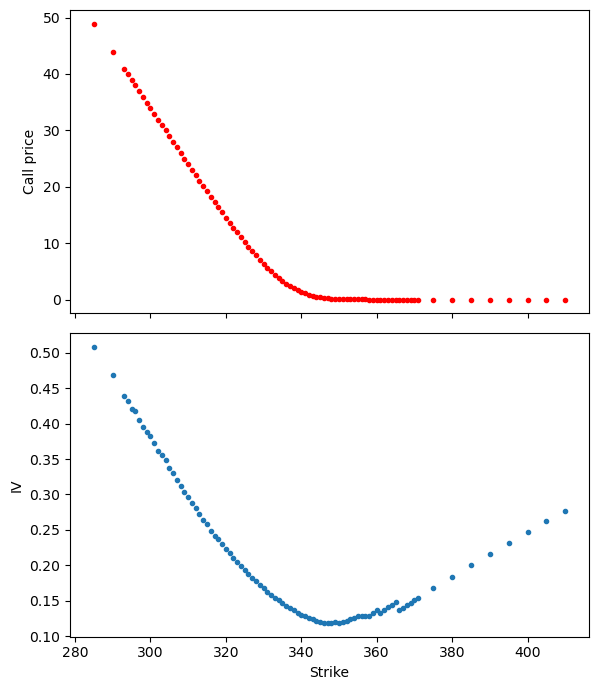

In [107]:
calls_no_na = calls.dropna()

fig, (ax1, ax2) = plt.subplots(2,1, figsize=(6,7), sharex=True)
ax1.plot(calls_no_na.strike, calls_no_na.midprice, "r.")
ax1.set_ylabel("Call price")
ax2.plot(calls_no_na.strike, calls_no_na.iv, ".")
ax2.set_ylabel("IV")
ax2.set_xlabel("Strike")
plt.tight_layout()
# plt.savefig("calls_to_iv.png", dpi=400)
plt.show()

In [108]:
calls_clean = calls.dropna().copy()
calls_clean["iv"] = gaussian_filter1d(calls_clean.iv, 3)

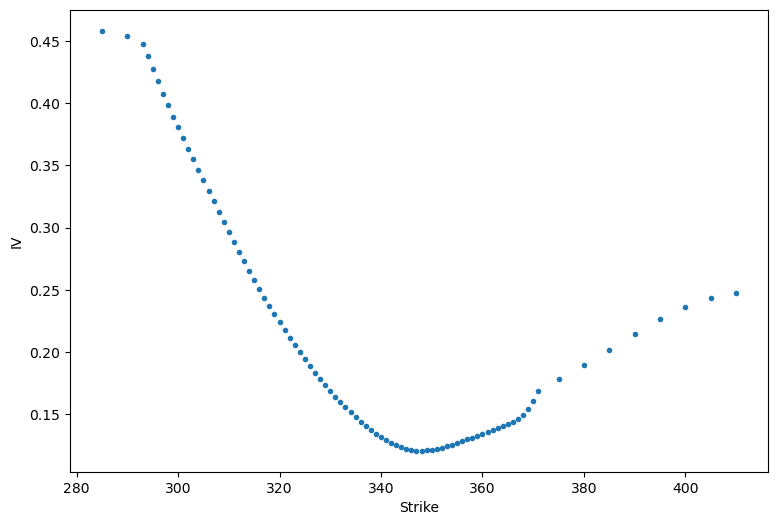

In [109]:
plot_vol_smile(calls_clean)

In [110]:
calls_clean = calls_clean[(calls_clean.strike > 300) & (calls_clean.strike < 375)]

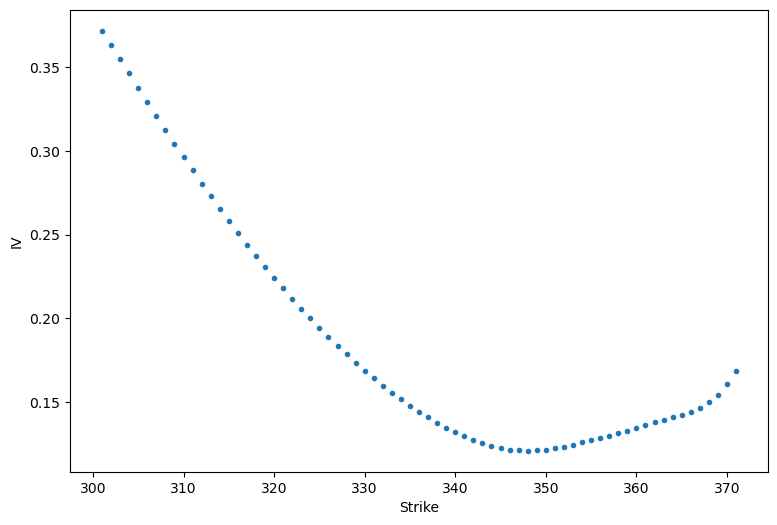

In [111]:
plot_vol_smile(calls_clean, savefig=False)

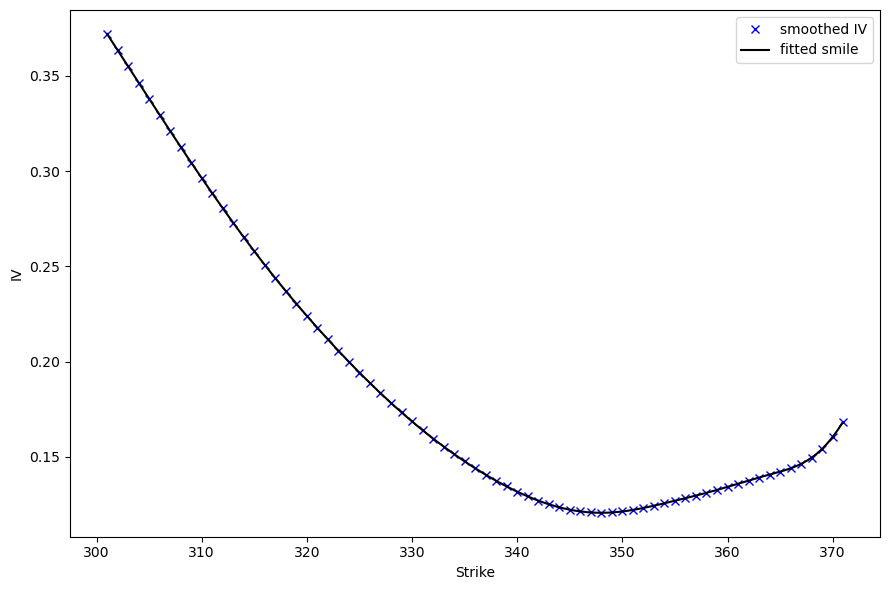

In [112]:
plt.figure(figsize=(9,6))
vol_surface = scipy.interpolate.interp1d(calls_clean.strike, calls_clean.iv, kind="cubic",
                                 fill_value="extrapolate")
x_new = np.arange(calls_clean.strike.min(), calls_clean.strike.max(), 0.1)
plt.plot(calls_clean.strike, calls_clean.iv, "bx", x_new, vol_surface(x_new), "k-");
plt.legend(["smoothed IV", "fitted smile"], loc="best")
plt.xlabel("Strike")
plt.ylabel("IV")
plt.tight_layout()
# plt.savefig("SPY_smile.png", dpi=300)
plt.show()

In [113]:
C_interp = call_value(S, x_new, vol_surface(x_new), t)

In [114]:
first_deriv = np.gradient(C_interp, x_new)
second_deriv = np.gradient(first_deriv, x_new)

In [115]:
def pdf2(Krange, S, t=0, r=0):
    # x is a range of strikes
    Crange = call_value(S, Krange, vol_surface(Krange), t, r)
    first_deriv = np.gradient(Crange, x_new, edge_order=0)
    second_deriv = np.gradient(first_deriv, x_new, edge_order=0)
    return np.exp(r * t) * second_deriv

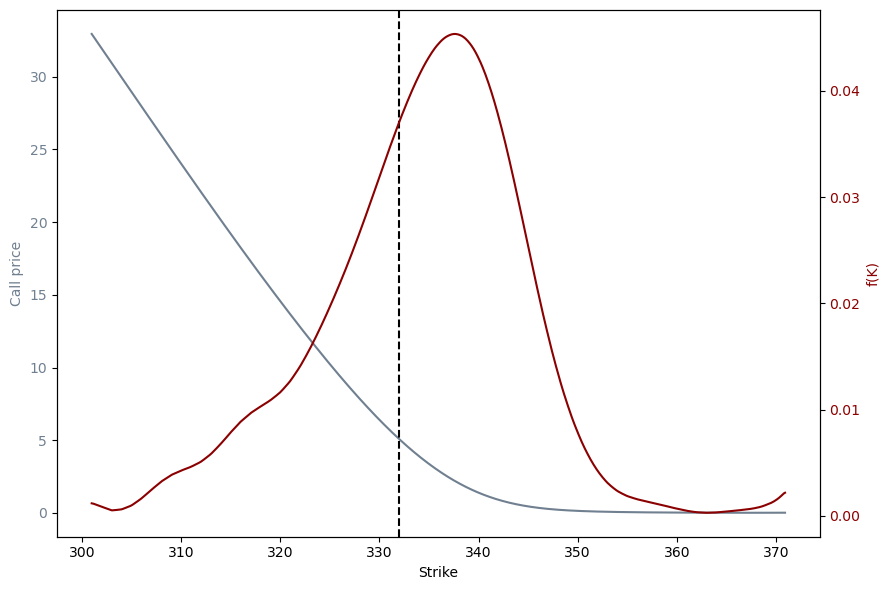

In [116]:
fig, ax1 = plt.subplots(figsize=(9,6))

col="slategrey"
ax1.set_xlabel('Strike')
ax1.set_ylabel('Call price', color=col)
ax1.plot(x_new, C_interp, color=col)
ax1.tick_params(axis='y', labelcolor=col)
ax1.axvline(332, color="k", linestyle="--")

ax2 = ax1.twinx()
col = 'darkred'
ax2.set_ylabel('f(K)', color=col)
ax2.plot(x_new, pdf2(x_new, S, t), color=col)
ax2.tick_params(axis='y', labelcolor=col)

fig.tight_layout()
# plt.savefig("volspace_pdf.png", dpi=300)
plt.show()

In [117]:
data = np.vstack([x_new, pdf2(x_new, S, t)]).T
data = data[(data[:, 0] < 360) & (data[:, 0] > 320)]
k, curve_pdf = np.hsplit(data, 2)

#### Create 2D array

In [118]:
# Flatten the arrays if they are 2D
k_flat = k.flatten()
curve_pdf_flat = curve_pdf.flatten()

# Create a 2D array for the original PDF
original_pdf = np.column_stack((k_flat, curve_pdf_flat))

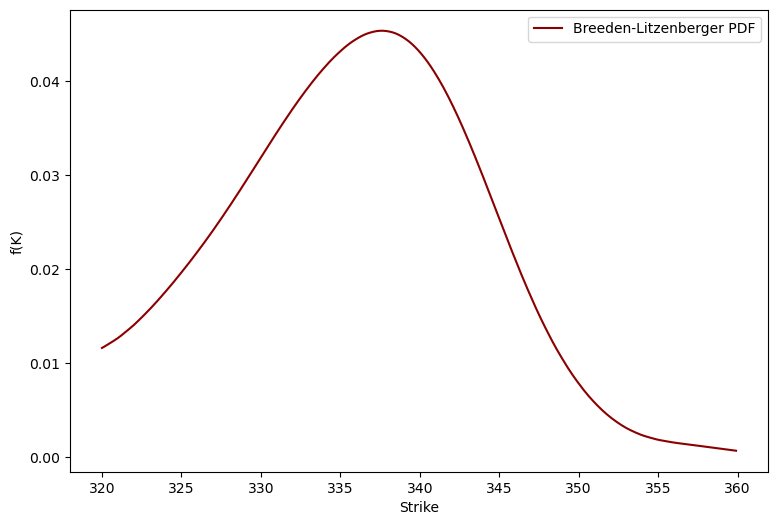

In [119]:
plt.figure(figsize=(9,6))
plt.plot(original_pdf[:, 0], original_pdf[:, 1], "darkred")
plt.xlabel("Strike")
plt.ylabel("f(K)")
plt.legend(["Breeden-Litzenberger PDF"], loc="best")
# plt.savefig("breeden_litzenberger_pdf.png", dpi=300)
plt.show()


C:\Users\ANDREAS\AppData\Local\Temp\ipykernel_13444\3535132552.py:7: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * (x - c))


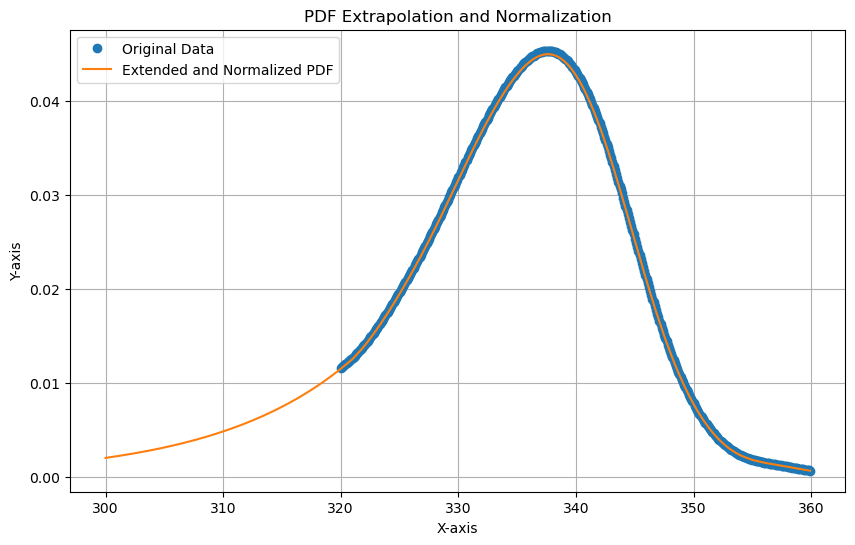

In [120]:

# Separate the original data into x and y components for clarity
x_original = original_pdf[:, 0]
y_original = original_pdf[:, 1]

# Define the exponential decay function
def exp_decay(x, a, b, c):
    return a * np.exp(-b * (x - c))

# Use the leftmost points of the original data to fit the exponential decay
left_points_x = x_original[:10]  # Use more points if necessary for a better fit
left_points_y = y_original[:10]
params, _ = curve_fit(exp_decay, left_points_x, left_points_y, p0=(1, 1, x_original[0]))

# Define the range for extrapolation
x_min_extrapolate = 300  # Adjust this as needed

# Generate new x values for extrapolation
x_extrapolate = np.linspace(x_min_extrapolate, x_original[0], num=100, endpoint=False)

# Generate new y values using the fitted exponential decay
y_extrapolate = exp_decay(x_extrapolate, *params)

# Combine the extrapolated points with the original data
extrapolated_pdf = np.column_stack((x_extrapolate, y_extrapolate))
new_pdf = np.vstack((extrapolated_pdf, original_pdf))

# Normalize the curve so the total area is 1
x_values = new_pdf[:, 0]
y_values = new_pdf[:, 1]
area = simps(y_values, x_values)
y_values_normalized = y_values / area

# Replace the y-values in new_pdf with normalized values
new_pdf[:, 1] = y_values_normalized

# Plot the original and the new PDF
plt.figure(figsize=(10, 6))
plt.plot(x_original, y_original, 'o', label='Original Data')
plt.plot(new_pdf[:, 0], new_pdf[:, 1], label='Extended and Normalized PDF')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('PDF Extrapolation and Normalization')
plt.legend()
plt.grid(True)
plt.show()


In [121]:
rn_pdf = new_pdf

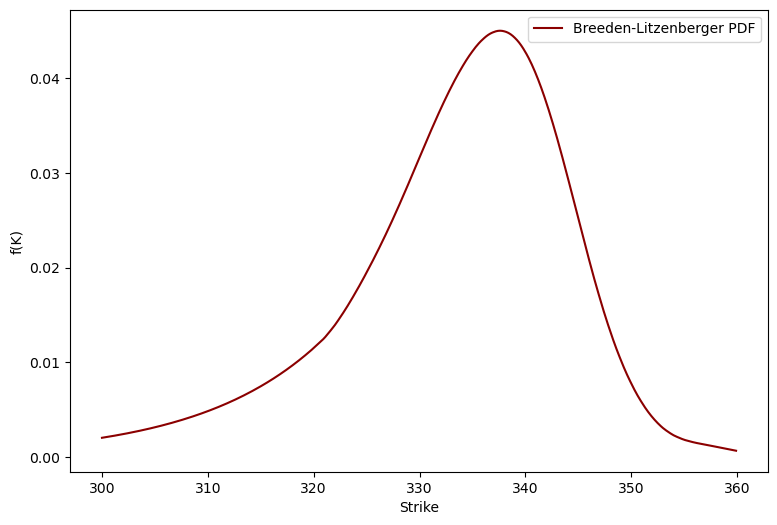

In [122]:
plt.figure(figsize=(9,6))
plt.plot(rn_pdf[:, 0], rn_pdf[:, 1], "darkred")
plt.xlabel("Strike")
plt.ylabel("f(K)")
plt.legend(["Breeden-Litzenberger PDF"], loc="best")
# plt.savefig("breeden_litzenberger_pdf.png", dpi=300)
plt.show()


### Define payoffs and useful functions

In [123]:
def reverse_convertible(x,K):
    if x <= K:
        return x
    else:
        return K 

In [124]:
import numpy as np
import matplotlib.pyplot as plt

def reverse_convertible_payoff(S_T, S_0, P, C, K):
    """
    Calculates the payoff of a reverse convertible.

    Parameters:
    S_T: Price of the underlying asset at maturity.
    S_0: Initial price of the underlying asset.
    P: Principal amount.
    C: Coupon payment.
    K: Strike price.

    Returns:
    Total payoff of the reverse convertible.
    """
    # Adjusted asset value based on the initial price
    adjusted_asset_value = P * S_T / S_0

    # The investor receives the adjusted asset value if it's below the principal, 
    # otherwise they receive the principal amount.
    asset_or_principal = min(P, adjusted_asset_value)

    # Total payoff is the sum of the coupon payment and the minimum of principal or adjusted asset value.
    return C + asset_or_principal

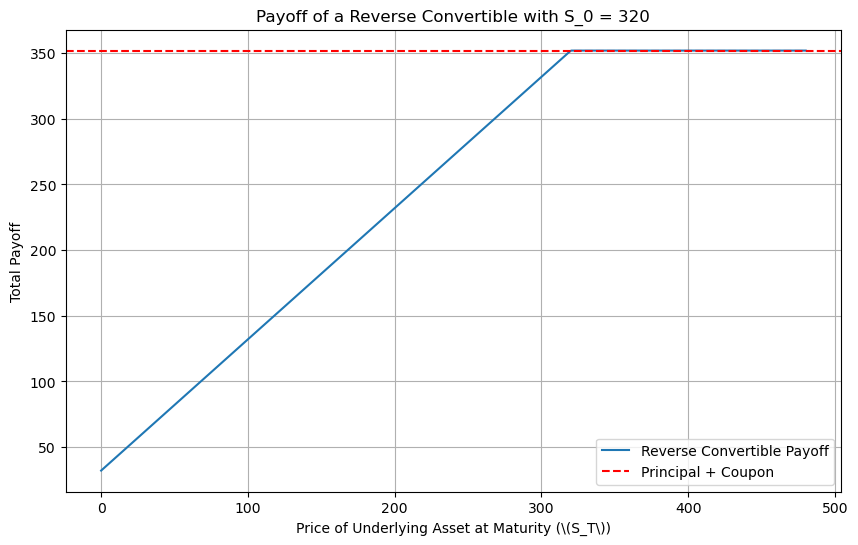

In [125]:
##PLOT EXAMPLE 

# Parameters
S_0 = 320  # Initial price of the underlying asset
P = S_0  # Principal amount (equal to S_0)
C = P * 0.10  # Coupon payment (10% of principal)
K = P  # Strike price equal to the principal

# Price of the underlying asset at maturity ranging from 0 to 1.5 times the initial price
S_T_values = np.linspace(0, 1.5 * S_0, 500)

# Calculate payoffs
payoffs = [reverse_convertible_payoff(S_T, S_0, P, C, K) for S_T in S_T_values]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(S_T_values, payoffs, label='Reverse Convertible Payoff')
plt.axhline(y=P + C, color='r', linestyle='--', label='Principal + Coupon')
plt.title('Payoff of a Reverse Convertible with S_0 = 320')
plt.xlabel('Price of Underlying Asset at Maturity (\(S_T\))')
plt.ylabel('Total Payoff')
plt.legend()
plt.grid(True)
plt.show()


In [126]:
#Function that is equal to F'(x)/F(x) for the reverse convertible
def derivative_to_payoff_ratio(S_T, S_0, P, C, K):
    """
    Calculates the ratio of the derivative of the reverse convertible payoff 
    to the payoff itself.

    Parameters:
    S_T: Price of the underlying asset at maturity.
    S_0: Initial price of the underlying asset.
    P: Principal amount.
    C: Coupon payment.
    K: Strike price.

    Returns:
    Ratio of the derivative of the payoff to the payoff itself.
    """
    # Calculate the reverse convertible payoff
    payoff = reverse_convertible_payoff(S_T, S_0, P, C, K)

    # Derivative is 1 before the strike and 0 after
    derivative = 1 if S_T < K else 0

    # Avoid division by zero
    if payoff == 0:
        return 0

    # Ratio calculation
    ratio = derivative / payoff if S_T < K else 0

    return ratio


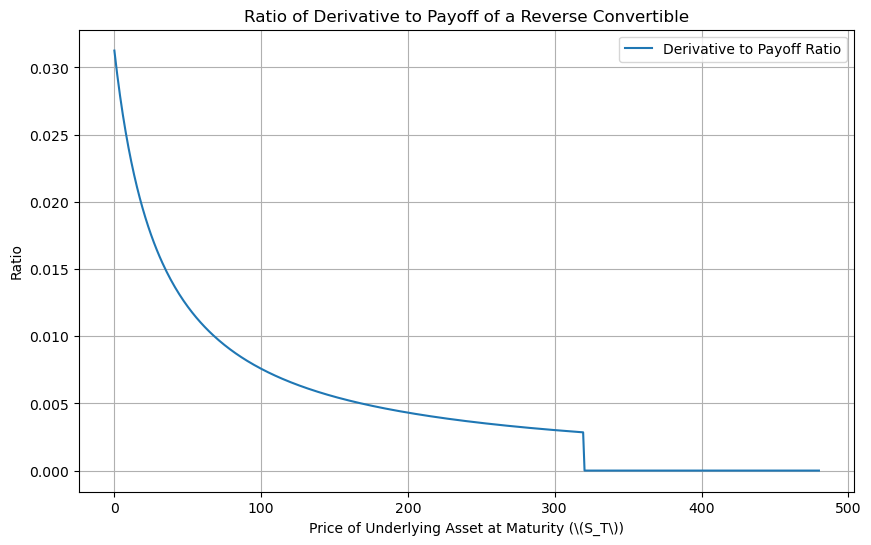

In [127]:
# Plotting the ratio for the same range of S_T values
ratio_values = [derivative_to_payoff_ratio(S_T, S_0, P, C, K) for S_T in S_T_values]

plt.figure(figsize=(10, 6))
plt.plot(S_T_values, ratio_values, label='Derivative to Payoff Ratio')
plt.title('Ratio of Derivative to Payoff of a Reverse Convertible')
plt.xlabel('Price of Underlying Asset at Maturity (\(S_T\))')
plt.ylabel('Ratio')
plt.legend()
plt.grid(True)
plt.show()


In [128]:

def ratio_function(x, growth_optimizer_payoff):
    # Function to compute the derivative
    def derivative_of_growth_optimizer(x):
        return derivative(growth_optimizer_payoff, x, dx=1e-6)
    
    # Function to compute the ratio of the original function to its derivative
    original_value = growth_optimizer_payoff(x)
    derivative_value = derivative_of_growth_optimizer(x)
    return original_value / derivative_value if derivative_value != 0 else np.inf

In [129]:
def relative_risk_aversion(x, growth_optimizer_payoff, general_payoff_ratio):
    return ratio_function(x, growth_optimizer_payoff) * general_payoff_ratio(x)

# Change pdf beliefs

In [158]:
#Measure the area under the pdf curves

def compute_area(pdf_array):
    """
    Compute the area under a given PDF represented as a 2D array.

    Parameters:
    pdf_array (numpy.ndarray): A 2D array where the first column contains the x-values (e.g., strike prices)
                               and the second column contains the corresponding PDF values.

    Returns:
    float: The area under the PDF curve.
    """
    x_values = pdf_array[:, 0]
    pdf_values = pdf_array[:, 1]
    area = trapz(pdf_values, x_values)
    return area

# Example usage:
area_under_rn_pdf = compute_area(rn_pdf)
print("Area under the PDF:", area_under_rn_pdf)


Area under the PDF: 1.0000016354197212


## Shift the pdf

In [131]:
# Flatten the arrays if they are 2D
# Assuming rn_pdf is already a 2D array with the first column for x-values and the second for y-values
k_flat = rn_pdf[:, 0].flatten()  # This is the x-values of rn_pdf
curve_pdf_flat = rn_pdf[:, 1].flatten()  # This is the y-values of rn_pdf

In [132]:
# Shift the rn_pdf to the right by "shift" units
shift = 5
shifted_pdf = np.column_stack((k_flat + shift, curve_pdf_flat))

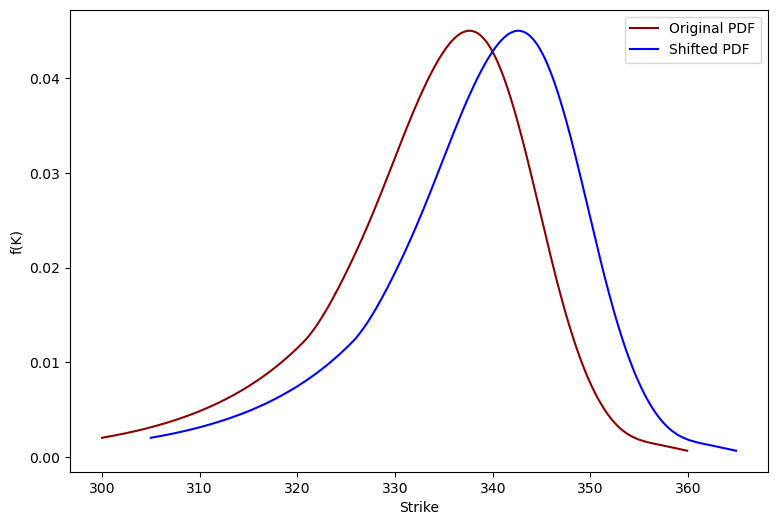

In [133]:
# Plot the original and shifted PDFs
plt.figure(figsize=(9, 6))

# Plot the original PDF (rn_pdf)
plt.plot(rn_pdf[:, 0], rn_pdf[:, 1], "darkred", label="Original PDF")

# Plot the shifted PDF
plt.plot(shifted_pdf[:, 0], shifted_pdf[:, 1], "blue", label="Shifted PDF")

plt.xlabel("Strike")
plt.ylabel("f(K)")
plt.legend(loc="best")
plt.show()


In [134]:
#COMPUTE THE GROWTH OPTIMIZER PAYOFF

# Interpolate the original PDF
rn_pdf_interp = interp1d(rn_pdf[:, 0], rn_pdf[:, 1], bounds_error=False, fill_value=0)

# Divide the shifted PDF by the interpolated original PDF
# Calculate the PDF values of the original PDF at the shifted strike prices
rn_pdf_values_at_shifted = rn_pdf_interp(shifted_pdf[:, 0])

# Handle division by zero by replacing zeros with a very small number
division = np.where(rn_pdf_values_at_shifted != 0, shifted_pdf[:, 1] / rn_pdf_values_at_shifted, 0)

# Create a function for the growth optimizer payoff
growth_optimizer_payoff_shift = interp1d(shifted_pdf[:, 0], division, kind='linear', fill_value='extrapolate')

C:\Users\ANDREAS\AppData\Local\Temp\ipykernel_13444\3301309537.py:11: RuntimeWarning: divide by zero encountered in true_divide
  division = np.where(rn_pdf_values_at_shifted != 0, shifted_pdf[:, 1] / rn_pdf_values_at_shifted, 0)


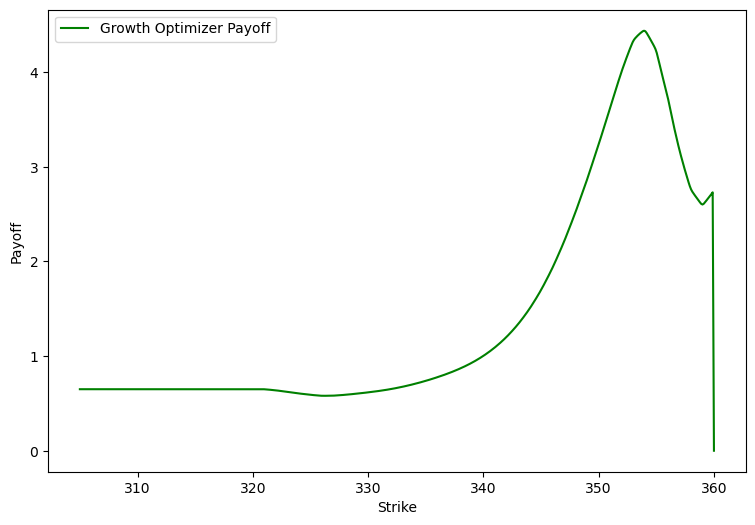

In [135]:

# Define the end of the range for plotting
end_range = min(360, np.max(shifted_pdf[:, 0]))

# Use a range of strike prices for plotting, stopping at 360 or the last available data point
strike_range = np.linspace(np.min(shifted_pdf[:, 0]), end_range, 500)

# Plot the growth optimizer payoff function
plt.figure(figsize=(9, 6))
plt.plot(strike_range, growth_optimizer_payoff_shift(strike_range), 'green', label='Growth Optimizer Payoff')

# Set labels and legend
plt.xlabel("Strike")
plt.ylabel("Payoff")
plt.legend(loc="best")

# Optionally save the figure
# plt.savefig("growth_optimizer_payoff.png", dpi=300)

plt.show()


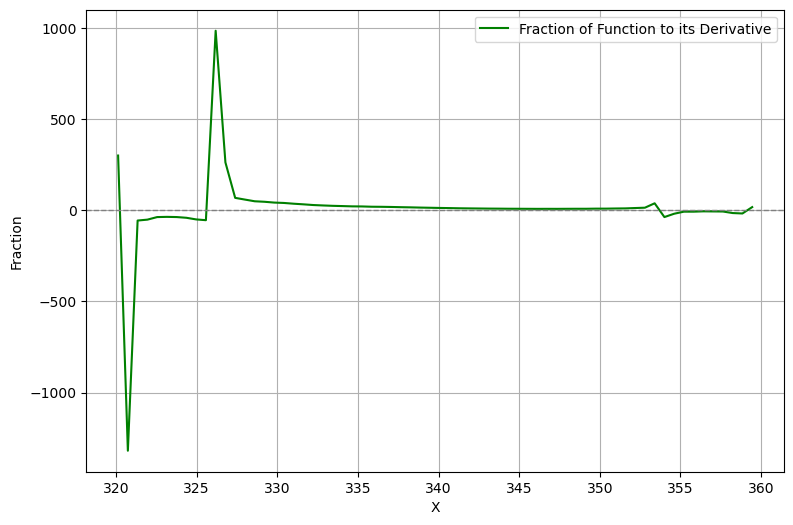

In [136]:
# Define a range of x values for plotting
x_range = np.linspace(np.min(growth_optimizer_payoff_shift.x), np.max(growth_optimizer_payoff_shift.x), 100)

# Compute the ratio for each x value in the range
ratios = [ratio_function(x, growth_optimizer_payoff_shift) for x in x_range]

# Plot the ratio
plt.figure(figsize=(9, 6))
plt.plot(x_range, ratios, 'green', label='Fraction of Function to its Derivative')
plt.axhline(y=1, color='gray', linestyle='--', linewidth=1)
plt.xlabel("X")
plt.ylabel("Fraction")
plt.legend(loc="best")
plt.grid(True) 
# plt.savefig("function_to_derivative_fraction.png", dpi=300)
plt.show()

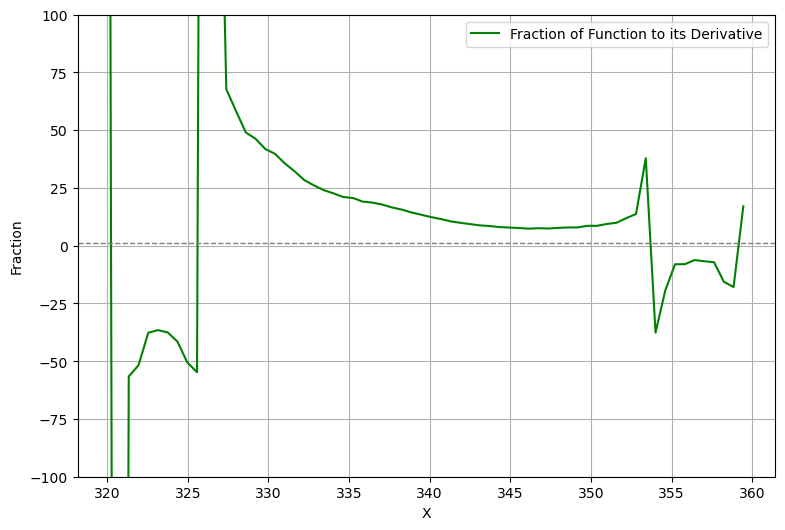

In [137]:

# Define a range of x values for plotting
x_range = np.linspace(np.min(shifted_pdf[:, 0]), np.max(shifted_pdf[:, 0]), 100)

# Compute the ratio for each x value in the range
# Since growth_optimizer_payoff_shift is already a function, you don't need to wrap it with lambda
ratios = [ratio_function(x, growth_optimizer_payoff_shift) for x in x_range]

# Plot the ratio
plt.figure(figsize=(9, 6))
plt.plot(x_range, ratios, 'green', label='Fraction of Function to its Derivative')
plt.axhline(y=1, color='gray', linestyle='--', linewidth=1)

# Set the vertical limit of the plot
plt.ylim(-100, 100)

plt.xlabel("X")
plt.ylabel("Fraction")
plt.legend(loc="best")
plt.grid(True) 
plt.show()


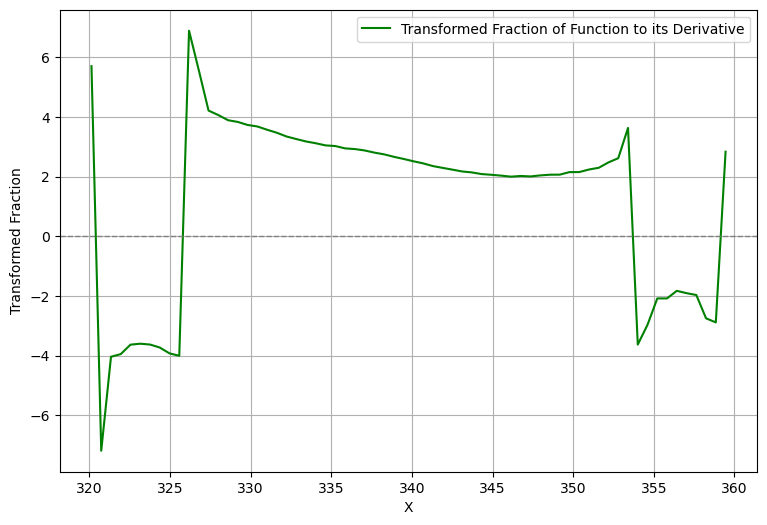

In [138]:

# Define a range of x values for plotting
x_range = np.linspace(np.min(shifted_pdf[:, 0]), np.max(shifted_pdf[:, 0]), 100)

# Compute the ratio for each x value in the range
ratios = [ratio_function(x, growth_optimizer_payoff_shift) for x in x_range]

# Apply logarithm to the absolute value and restore the sign
log_ratios = np.sign(ratios) * np.log(np.abs(ratios))

# Plot the transformed ratios
plt.figure(figsize=(9, 6))
plt.plot(x_range, log_ratios, 'green', label='Transformed Fraction of Function to its Derivative')
plt.axhline(y=0, color='gray', linestyle='--', linewidth=1)  # y=0 because log(1) = 0

plt.xlabel("X")
plt.ylabel("Transformed Fraction")
plt.legend(loc="best")
plt.grid(True) 
plt.show()


In [139]:
def maximum_of_function(f):
    def negative_function(x):
        return -f(x)

    # Find the maximum using minimize_scalar within the bounds of your data
    result = minimize_scalar(negative_function, bounds=(np.min(growth_optimizer_payoff_shift.x), np.max(growth_optimizer_payoff_shift.x)), method='bounded')

    # The maximum value and the point where it is achieved
    max_value = -result.fun
    max_point = result.x
    
    return max_value, max_point

C:\Users\ANDREAS\AppData\Local\Temp\ipykernel_13444\90451916.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  risk_aversion = [1/relative_risk_aversion(x, growth_optimizer_payoff_shift, rv_fr) for x in x_range]


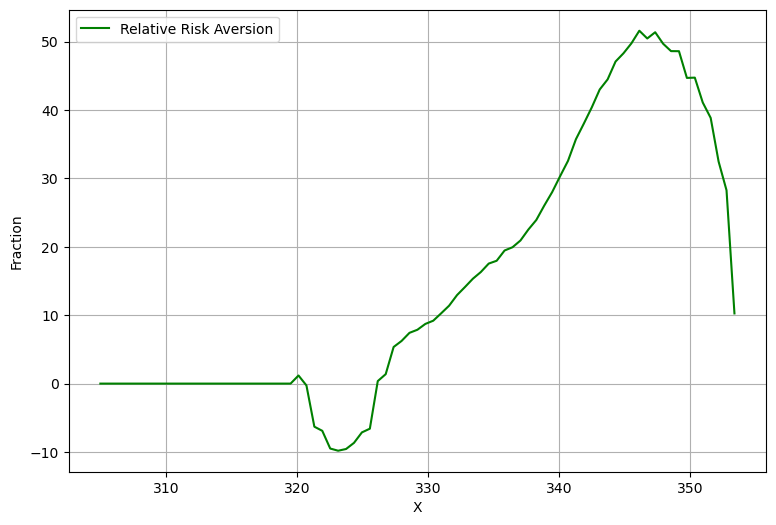

In [140]:
max_value, K = maximum_of_function(growth_optimizer_payoff_shift)

def rv_fr(x):
    return derivative_to_payoff_ratio(x, K, K, 0.10*K, K)  

x_range = np.linspace(np.min(growth_optimizer_payoff_shift.x), np.max(growth_optimizer_payoff_shift.x), 100)
risk_aversion = [1/relative_risk_aversion(x, growth_optimizer_payoff_shift, rv_fr) for x in x_range]

plt.figure(figsize=(9, 6))
plt.plot(x_range, risk_aversion, 'green', label='Relative Risk Aversion')
plt.xlabel("X")
plt.ylabel("Fraction")
plt.legend(loc="best")
plt.grid(True)

plt.show()


## Change volatility

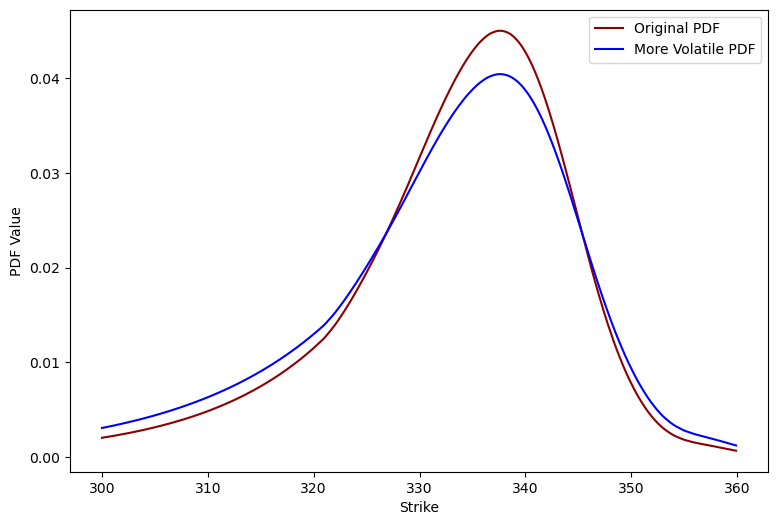

In [141]:
# Step 1: Increase volatility with a non-linear transformation
volatility_increase = 1.2  # Adjust this for more or less volatility
new_pdf_values = np.copy(rn_pdf[:, 1])
new_pdf_values = np.power(new_pdf_values, 1 / volatility_increase)

# Step 2: Normalize the new PDF
original_area = trapz(rn_pdf[:, 1], rn_pdf[:, 0])
new_area = trapz(new_pdf_values, rn_pdf[:, 0])
new_pdf_values *= (original_area / new_area)

# Step 3: Create the more volatile PDF
more_volatile_pdf = np.column_stack((rn_pdf[:, 0], new_pdf_values))

# Step 4: Plot both PDFs for comparison
plt.figure(figsize=(9,6))
plt.plot(rn_pdf[:, 0], rn_pdf[:, 1], 'darkred', label='Original PDF')
plt.plot(more_volatile_pdf[:, 0], more_volatile_pdf[:, 1], 'blue', label='More Volatile PDF')
plt.xlabel('Strike')
plt.ylabel('PDF Value')
plt.legend()
plt.show()

In [142]:
#COMPUTE THE GROWTH OPTIMIZER PAYOFF

# Interpolate the original PDF
original_pdf_interp = interp1d(rn_pdf[:, 0], rn_pdf[:, 1], bounds_error=False, fill_value=0)

# Divide the more volatile PDF by the interpolated original PDF
# Calculate the PDF values of the original PDF at the more volatile PDF's strike prices
original_pdf_values_at_more_volatile = original_pdf_interp(more_volatile_pdf[:, 0])

# Perform the division
division = more_volatile_pdf[:, 1] / np.where(original_pdf_values_at_more_volatile != 0, 
                                              original_pdf_values_at_more_volatile, 1)

# Create a function for the growth optimizer payoff
growth_optimizer_payoff_vol = interp1d(more_volatile_pdf[:, 0], division, kind='linear', fill_value='extrapolate')



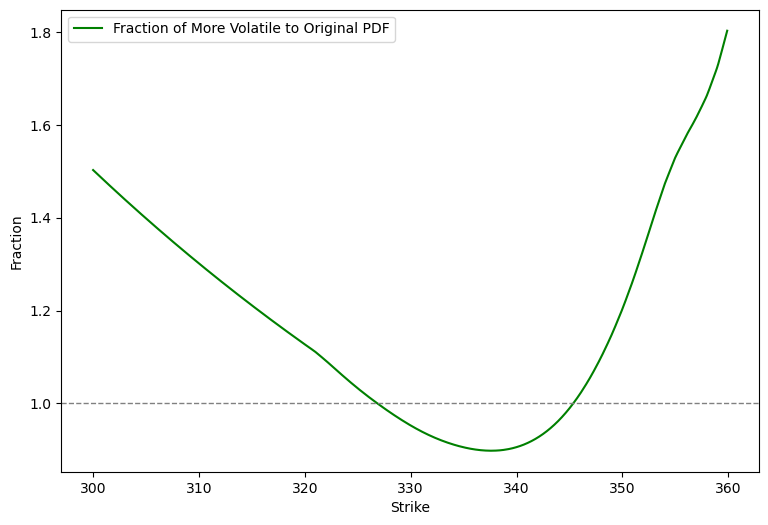

In [143]:
# Plot the function
plt.figure(figsize=(9,6))

# Use a range of strike prices for plotting
strike_range = np.linspace(np.min(more_volatile_pdf[:, 0]), np.max(more_volatile_pdf[:, 0]), 500)
plt.plot(strike_range, growth_optimizer_payoff_vol(strike_range), 'green', label='Fraction of More Volatile to Original PDF')
plt.axhline(y=1, color='gray', linestyle='--', linewidth=1)
plt.xlabel("Strike")
plt.ylabel("Fraction")
plt.legend(loc="best")
# plt.savefig("more_volatile_to_original_fraction.png", dpi=300)
plt.show()

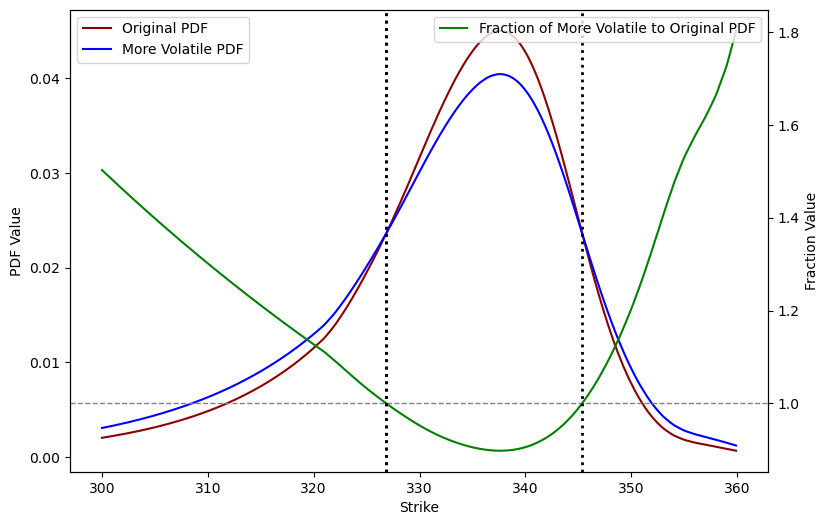

In [144]:
#PLOT TOGETHER WITH SCALED PDFs


plt.figure(figsize=(9,6))

# Plot the Original PDF and More Volatile PDF
plt.plot(rn_pdf[:, 0], rn_pdf[:, 1], 'darkred', label='Original PDF')
plt.plot(more_volatile_pdf[:, 0], more_volatile_pdf[:, 1], 'blue', label='More Volatile PDF')

plt.xlabel("Strike")
plt.ylabel("PDF Value")
plt.legend(loc="upper left")

# Create secondary y-axis for the fraction
ax2 = plt.gca().twinx()

# Calculate and Plot the Fraction of More Volatile to Original PDF on the secondary y-axis
strike_range = np.linspace(np.min(more_volatile_pdf[:, 0]), np.max(more_volatile_pdf[:, 0]), 1000)
fractions = growth_optimizer_payoff_vol(strike_range)
ax2.plot(strike_range, fractions, 'green', label='Fraction of More Volatile to Original PDF')

# Add a horizontal line at y=1 for reference on the secondary y-axis
ax2.axhline(y=1, color='gray', linestyle='--', linewidth=1)
ax2.set_ylabel("Fraction Value")
ax2.legend(loc="upper right")

# Add more visible vertical dotted lines where the fraction is approximately 1
tolerance = 0.001  # Very small tolerance for precision
equal_points = strike_range[np.abs(fractions - 1) < tolerance]
for x in equal_points:
    plt.axvline(x=x, color='black', linestyle=':', linewidth=2)

plt.show()


### Take implied risk aversion

In [145]:
def ratio_function(x, growth_optimizer_payoff):
    # Function to compute the derivative
    def derivative_of_growth_optimizer(x):
        return derivative(growth_optimizer_payoff, x, dx=1e-6)
    
    # Function to compute the ratio of the original function to its derivative
    original_value = growth_optimizer_payoff(x)
    derivative_value = derivative_of_growth_optimizer(x)
    return original_value / derivative_value if derivative_value != 0 else np.inf

In [146]:
def relative_risk_aversion(x, growth_optimizer_payoff, general_payoff_ratio):
    return ratio_function(x, growth_optimizer_payoff) * general_payoff_ratio(x)

C:\Users\ANDREAS\AppData\Local\Temp\ipykernel_13444\1726943306.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  risk_aversion = [1/relative_risk_aversion(x, growth_optimizer_payoff_vol, rv_fr) for x in x_range]


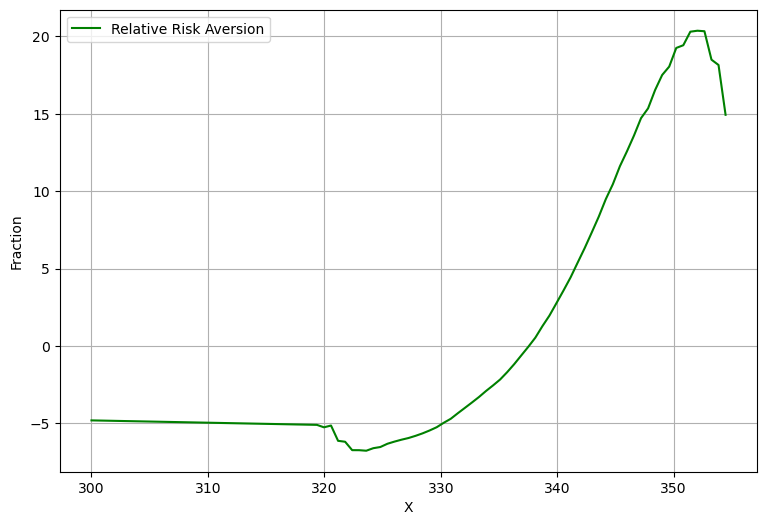

In [147]:


K = 355

def rv_fr(x):
    return derivative_to_payoff_ratio(x, K, K, 0.10*K, K)  

x_range = np.linspace(np.min(growth_optimizer_payoff_vol.x), np.max(growth_optimizer_payoff_vol.x), 100)
risk_aversion = [1/relative_risk_aversion(x, growth_optimizer_payoff_vol, rv_fr) for x in x_range]

plt.figure(figsize=(9, 6))
plt.plot(x_range, risk_aversion, 'green', label='Relative Risk Aversion')
plt.xlabel("X")
plt.ylabel("Fraction")
plt.legend(loc="best")
plt.grid(True)

plt.show()


## Belief of a RC investor

An investor who buys a rreverse convertible with strike ATM expects low volatility and that the price of the underlying will make a slight rise. So his belief on the pdf of the underlying could be the following.

In [180]:
def compute_expectation(pdf_array):
    """
    Compute the expectation of a given PDF represented as a 2D array using a numerical method.

    Parameters:
    pdf_array (numpy.ndarray): A 2D array where the first column contains the x-values,
                               and the second column contains the corresponding PDF values.

    Returns:
    float: The expectation value of the PDF.
    """
    x_values = pdf_array[:, 0]
    pdf_values = pdf_array[:, 1]

    # Compute x * f(x)
    x_times_pdf = x_values * pdf_values

    # Compute the integral of x * f(x)
    expectation = trapz(x_times_pdf, x_values)
    return expectation

# Compute the expectation
expectation_value = compute_expectation(rn_pdf)
print("Expectation:", expectation_value)


Expectation: 333.4983464535587


So the market (risk neutral pdf) expects that the price of the underline will slightly rise from 332 to 333.5. Now lets assume that the investor believes that the price will rise to 336.2 (mean) and the volatility will be small. Then his belief might be.

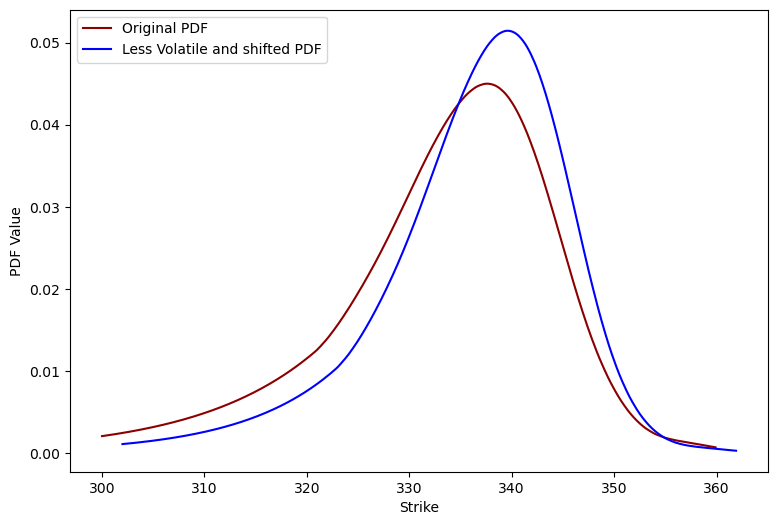

In [199]:
# Step 1: Decrese volatility with a non-linear transformation
volatility_increase = 0.8  # Adjust this for more or less volatility
new_pdf_values = np.copy(rn_pdf[:, 1])
new_pdf_values = np.power(new_pdf_values, 1 / volatility_increase)

# Step 2: Normalize the new PDF
original_area = trapz(rn_pdf[:, 1], rn_pdf[:, 0])
new_area = trapz(new_pdf_values, rn_pdf[:, 0])
new_pdf_values *= (original_area / new_area)

# Step 3: Create the less volatile and shifted PDF
shift = 2
rc_pdf = np.column_stack((rn_pdf[:, 0] + shift, new_pdf_values))

# Step 4: Plot both PDFs for comparison
plt.figure(figsize=(9,6))
plt.plot(rn_pdf[:, 0], rn_pdf[:, 1], 'darkred', label='Original PDF')
plt.plot(rc_pdf[:, 0], rc_pdf[:, 1], 'blue', label='Less Volatile and shifted PDF')
plt.xlabel('Strike')
plt.ylabel('PDF Value')
plt.legend()
plt.show()

In [200]:
#COMPUTE THE GROWTH OPTIMIZER PAYOFF

# Interpolate the original PDF
original_pdf_interp = interp1d(rn_pdf[:, 0], rn_pdf[:, 1], bounds_error=False, fill_value=0)

# Divide the more volatile PDF by the interpolated original PDF
# Calculate the PDF values of the original PDF at the more volatile PDF's strike prices
original_pdf_values_at_rc_pdf = original_pdf_interp(rc_pdf[:, 0])

# Perform the division
division = rc_pdf[:, 1] / np.where(original_pdf_values_at_rc_pdf != 0, 
                                              original_pdf_values_at_rc_pdf, 1)

# Create a function for the growth optimizer payoff
growth_optimizer_payoff_rc = interp1d(rc_pdf[:, 0], division, kind='linear', fill_value='extrapolate')

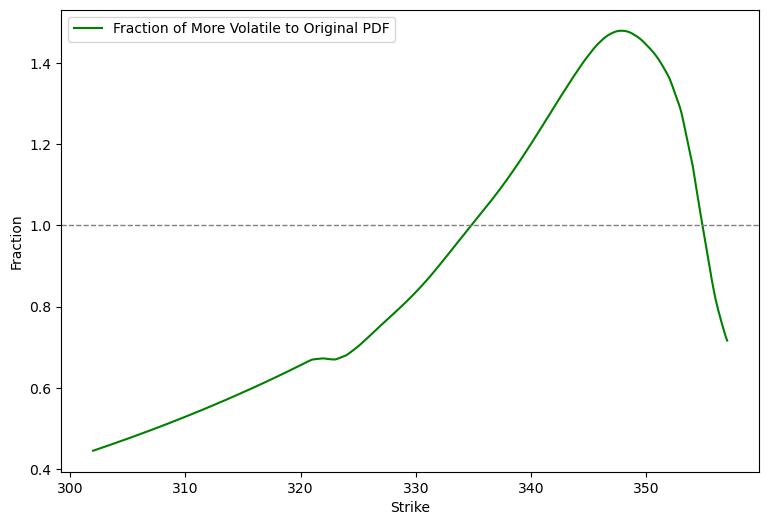

In [201]:
# Plot the function
plt.figure(figsize=(9,6))

# Use a range of strike prices for plotting
strike_range = np.linspace(np.min(rc_pdf[:, 0]), 357, 500)
plt.plot(strike_range, growth_optimizer_payoff_rc(strike_range), 'green', label='Fraction of More Volatile to Original PDF')
plt.axhline(y=1, color='gray', linestyle='--', linewidth=1)
plt.xlabel("Strike")
plt.ylabel("Fraction")
plt.legend(loc="best")
# plt.savefig("more_volatile_to_original_fraction.png", dpi=300)
plt.show()

C:\Users\ANDREAS\AppData\Local\Temp\ipykernel_13444\1886844754.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  risk_aversion = [1/relative_risk_aversion(x, growth_optimizer_payoff_rc, rv_fr) for x in x_range]


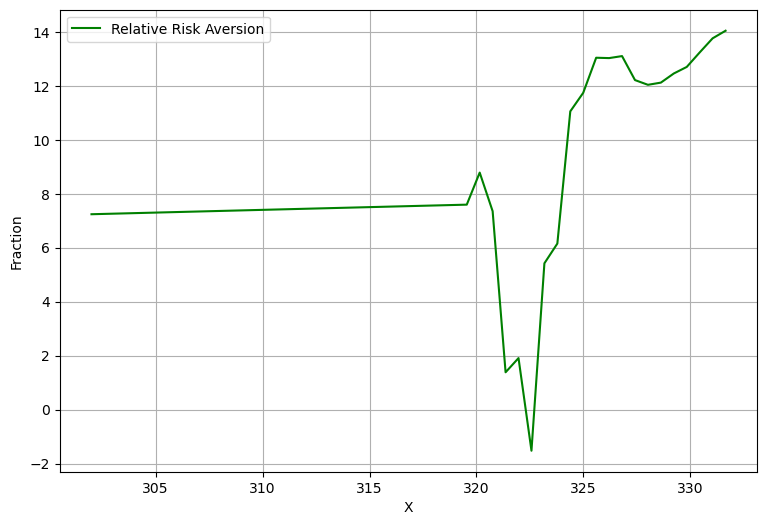

In [202]:
K = 332

def rv_fr(x):
    return derivative_to_payoff_ratio(x, K, K, 0.10*K, K)  

x_range = np.linspace(np.min(growth_optimizer_payoff_rc.x), np.max(growth_optimizer_payoff_rc.x), 100)
risk_aversion = [1/relative_risk_aversion(x, growth_optimizer_payoff_rc, rv_fr) for x in x_range]

plt.figure(figsize=(9, 6))
plt.plot(x_range, risk_aversion, 'green', label='Relative Risk Aversion')
plt.xlabel("X")
plt.ylabel("Fraction")
plt.legend(loc="best")
plt.grid(True)

plt.show()
